# Adaptive Dynamic Programming
 - Continuous-time systems
 - Off-policy

### Actor-critic scheme
 - Single NN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# Time parameters
dt = 0.001
T = 500
time = np.arange(0, T + dt, dt)
len1 = len(time)

In [3]:
# Generate white Gaussian noise
# Note: wgn in MATLAB is replaced with normal distribution in numpy
X = np.random.normal(0, 10 ** (-10 / 20), (2, len1))  # -10 dB noise power

Critic NN:

$\hat{V}(x)=\hat{W}_v^T \mu_v(x)$

Control law:

$\hat{u}(x)=-\frac{1}{2}R^{-1}B^T(x) \left(\nabla \mu_v(x)\right)^T \hat{W}_v$

In [4]:
# Initialize arrays
W_v = np.zeros((3, len1))
u = np.zeros((2, len1))
Wd0 = np.zeros((3, 1))

In [5]:
# System matrices
A = np.array([[0, 1], [-2, -4]])
g = np.array([[1, 2], [0, 1]])
r = np.diag([0.01, 0.01])
q = np.diag([50, 50])
# Solve continuous-time algebraic Riccati equation
XX = linalg.solve_continuous_are(A, g, q, r)
# Note: L and G outputs from MATLAB's care aren't directly available in scipy
# but can be computed if needed: L = np.linalg.inv(r) @ g.T @ XX, G = g @ np.linalg.inv(r) @ g.T

x_d = np.zeros((2, 1))

In [6]:
# Main loop
for i in range(len1 - 1):
    t = time[i]

    # State calculation
    x = X[:, i].reshape(2, 1) * len1 / (i + 1 * 10)
    f = A @ x

    x1 = x[0, 0]
    x2 = x[1, 0]

    # Compute mu_v and dmu_v
    mu_v = np.array([[x1 ** 2], [x1 * x2], [x2 ** 2]])
    dmu_v = np.array([[2 * x1, 0],
                      [x2, x1],
                      [0, 2 * x2]])

    # Calculate control input
    u[:, i:i + 1] = -0.5 * np.linalg.solve(r, g.T) @ dmu_v.T @ W_v[:, i:i + 1]

    # Compute phi
    phi = dmu_v @ (f + g @ u[:, i:i + 1])
    # Compute V
    V = W_v[:, i:i + 1].T @ mu_v

    # Compensation Term
    # Note that this term is needed ONLY in the case of ON-Policy Training To stabilize the system
    k_s = 0
    # Compute dJ_s
    dJ_s = x
    # # Check condition for k_s
    # if (dJ_s.T @ (f + g @ u[:, i:i + 1]))[0, 0] < 0:
    #     k_s = 0
    # else:
    #     k_s = 0.0001
    Delta = 0.5 * k_s * (dmu_v @ g @ np.linalg.solve(r, g.T)) @ dJ_s

    k_v = 10
    # Compute Wdot_v
    phi_norm = 1 + phi.T @ phi
    Wdot_v = (-k_v * phi / (phi_norm ** 2) *
              (x.T @ q @ x + u[:, i:i + 1].T @ r @ u[:, i:i + 1] +
               phi.T @ W_v[:, i:i + 1])[0, 0] + Delta)

    # Update W_v using second-order approximation
    a = (Wdot_v - Wd0) / dt
    W_v[:, i + 1:i + 2] = W_v[:, i:i + 1] + Wd0 * dt + 0.5 * a * dt ** 2
    Wd0 = Wdot_v

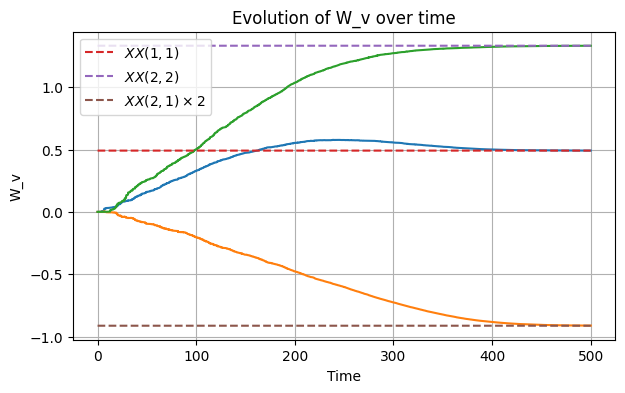

In [12]:
# Plot results
plt.figure(figsize=(7, 4))
plt.plot(time, W_v.T)
plt.plot(time, np.ones_like(time) * XX[0, 0], '--', label=r'$XX(1,1)$')
plt.plot(time, np.ones_like(time) * XX[1, 1], '--', label=r'$XX(2,2)$')
plt.plot(time, np.ones_like(time) * XX[1, 0] * 2, '--', label=r'$XX(2,1) \times 2$')
plt.xlabel('Time')
plt.ylabel('W_v')
plt.title('Evolution of W_v over time')
plt.grid(True)
plt.legend()
plt.show()